# Imports, load data

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import itertools
from collections import defaultdict, OrderedDict

from IPython.display import clear_output, display
from ipywidgets import IntProgress, Text, Layout, Label

from src.lai import compute_window_accuracies, assign_ancestries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
f = open('data/imputations_t50.p', 'rb')
imputations = pkl.load(f)
f.close()

In [4]:
H_AFR = np.loadtxt('data/H_AFR.txt')
H_AMR = np.loadtxt('data/H_AMR.txt')
H_EAS = np.loadtxt('data/H_EAS.txt')
H_EUR = np.loadtxt('data/H_EUR.txt')

H_valid = np.zeros((0, H_AFR.shape[1]))
for H in [H_AFR, H_AMR, H_EUR, H_EAS]:
    H_valid = np.vstack([H_valid, H[-50:, :]])
    
del H_AFR, H_AMR, H_EAS, H_EUR

In [18]:
pops = ['AFR', 'AMR', 'EAS', 'EUR']
for (p1, p2) in itertools.combinations(pops, 2):
    print(p1, p2, np.mean((imputations[p1] - imputations[p2])**2))

AFR AMR 0.06479067930489732
AFR EAS 0.13982161664033702
AFR EUR 0.14556411269088995
AMR EAS 0.12655805687203792
AMR EUR 0.11993483412322276
EAS EUR 0.18099789362822538


# Compute window accuracies

In [27]:
prog = IntProgress(value=0, max=H_valid.shape[1])
display(prog)

text = Text(value='', layout=Layout(width='100%'))
display(text)

def hook(col, accuracies):
    if (col % 50) == 0:
        clear_output()
        display(prog)
        display(text)
        text.value = ''
        for p, accs in accuracies.items():
            m, s = np.mean(accs[:, -1]), np.std(accs[:, -1])
            text.value += '%s:(%.3f, %.3f)  ' % (p, m, s)
        
    prog.value = col
    
accs = compute_window_accuracies(
    imputations, H_valid, window_size=10, hooks=[hook]
)

prog.close()
text.close()

# e = 206
# imputations['EUR'][:, -e:].sum()



IntProgress(value=7549, max=7596)

Text(value='EUR:(0.720, 0.142)  AMR:(0.712, 0.138)  EAS:(0.693, 0.153)  AFR:(0.699, 0.159)  ', layout=Layout(w…

## Save results

In [28]:
save_path = 'data/accuracies_td50.p'

out = dict()
out['model_info'] = imputations['model_info']
out['H_valid_info'] = imputations['H_valid_info']
out['accuracies'] = accs
try:
    f = open(save_path, 'wb')
    pkl.dump(out, f)
except:
    print('Saving accuracies failed.')
finally:
    f.close()

# Assign local ancestries

In [31]:
prog = IntProgress(value=0, max=100)
display(prog)

def hook(i, g_row):
    prog.value = i

ancestries = assign_ancestries(accs, hooks=[hook])

prog.close()

IntProgress(value=0)

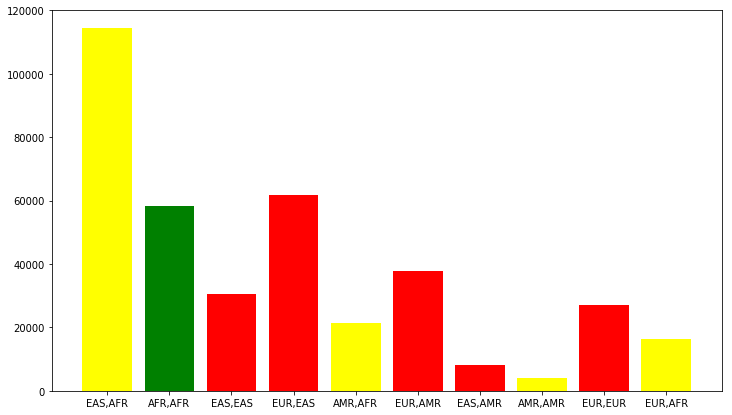

In [39]:
ans_AFR = defaultdict(int)
for row in range(0, 50):
#     ans_AFR.update(set(list(np.unique(ancestries[row]))))
    ans, cts = np.unique(ancestries[row], return_counts=True)
    for a, c in zip(ans, cts):
        ans_AFR[a] += c
    
#     print('='*30)
#     print('Row %d' % row)
#     for (a, c) in zip(ans, cts):
#         print(tuple(a), ':', c)
        
#     input()
#     clear_output()

to_plt = OrderedDict()
for anc, num in ans_AFR.items():
    if len(anc) == 1:
        k = ','.join(list(anc)*2)
    elif len(anc) == 2:
        k = ','.join(list(anc))
        
    to_plt[k] = num

f, ax = plt.subplots(figsize=(12, 7))

colors = []
for anc, num in to_plt.items():
    if anc == 'AFR,AFR':
        colors.append('green')
    elif ('AFR' in anc) or (anc == 'AMR,AMR'):
        colors.append('yellow')
    else:
        colors.append('red')

bar_space = 1
xs = np.arange(0, bar_space * len(to_plt.keys()), bar_space)
ax.bar(xs, list(to_plt.values()), tick_label=list(to_plt.keys()), color=colors)
plt.show()
    